GroundingDINO
====

**Grounding DINO: Marrying DINO with Grounded Pre-Training for Open-Set Object Detection**
 * Paper: https://arxiv.org/abs/2303.05499

![GroundingDINO](../assets/groundingdino_overview.png)

```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [1]:
import torch
from PIL import Image
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

from transformers import AutoProcessor
from transformers import AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id)

model.eval().to(device);

In [2]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")

text = "a plant. a vase."

inputs = processor(
    images=image, text=text, return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

results

[{'scores': tensor([0.4790, 0.4350], device='cuda:0'),
  'labels': ['a vase', 'a plant'],
  'boxes': tensor([[500.4077, 493.9652, 787.2032, 795.4719],
          [133.3739, 480.4415, 461.9477, 693.7854]], device='cuda:0')}]

In [3]:
def visualize_bboxes(image, predictions):
    bboxes = predictions["boxes"].cpu().numpy()
    labels = predictions["labels"]
    scores = predictions["scores"].cpu().numpy()
    uniq_labels = np.unique(labels)
    # map labels to class ids
    class_map = {label: i for i, label in enumerate(uniq_labels)}
    print(class_map)

    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes,
        class_id=np.array([class_map[label] for label in labels]),
        confidence=scores,
    )
    annotator = sv.BoxAnnotator()
    annotated_image = annotator.annotate(
        scene=image.copy(),
        detections=detections,
    )
    label_annotator = sv.LabelAnnotator(
        text_scale=1.0,
        #text_position=sv.Position.CENTER
    )
    text_labels = [
        f"{label} {score: 0.2f}"
        for label, score in zip(labels, scores)
    ]
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=text_labels
    )

    return annotated_image

{'a plant': 0, 'a vase': 1}
bboxes: (2, 4)


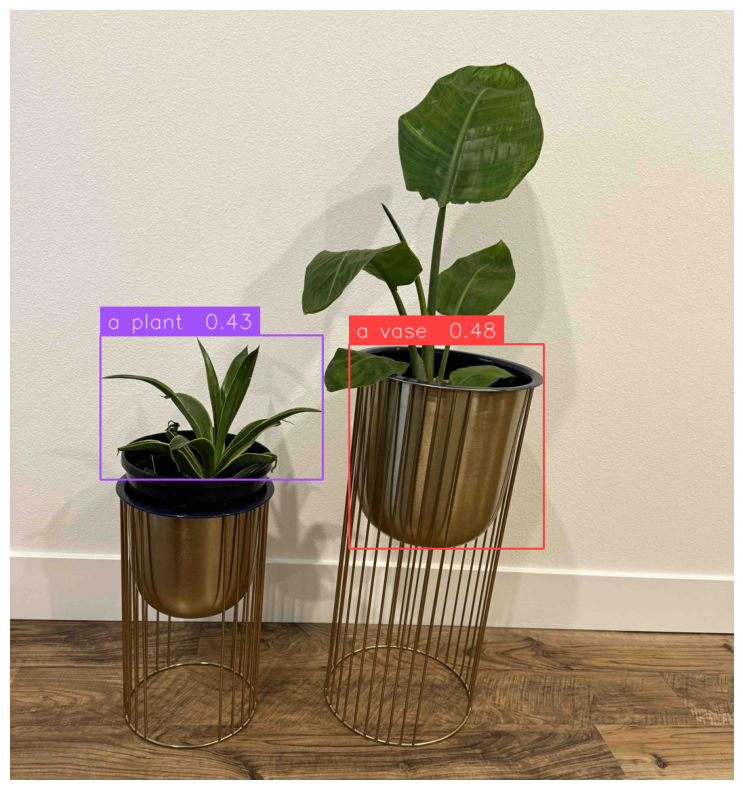

In [4]:
visualized_image = visualize_bboxes(image, results[0])
plt.figure(figsize=(10, 10))
plt.imshow(visualized_image)
plt.axis("off")
plt.show()